In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime


from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, \
    plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score, mean_squared_error


from sklearn.linear_model import (
    Ridge,RidgeCV,
    Lasso,LassoCV,
    ElasticNet, ElasticNetCV,
    LinearRegression
)

from sklearn.model_selection import(
    cross_val_score,
    train_test_split
)

from sklearn.preprocessing import (
    StandardScaler,
)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance

from xgboost import XGBClassifier
from xgboost import cv
from xgboost import plot_importance
import xgboost as xgb
use_label_encoder=False

# pd.set_option('display.max_rows', 1000)  # or 1000
pd.set_option('display.max_columns', 50)  # or 1000

C:\Users\User\.conda\envs\dsi\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [7]:
# Import Data

#train = pd.read_csv('../data/train.csv')
#test = pd.read_csv('../data/test.csv')

# Identify traps which are hotspots

In [175]:
# import data

merge_df = pd.read_csv('../data/merged_train.csv')

# create time related features

merge_df['date']=pd.to_datetime(merge_df['date'])
merge_df['year'] = merge_df['date'].dt.year
merge_df['month'] = merge_df['date'].dt.month
merge_df['week'] = merge_df['date'].dt.isocalendar().week

# subset required columns and rows
betw_year = merge_df[['trap', 'year', 'wnvpresent', 'wnvcount']]
betw_year = betw_year.loc[betw_year['wnvpresent']>0,:]           # only rows where wnv is present

# Collapse by trap and year
betw_year = betw_year.groupby(['trap', 'year'], as_index=False)[['wnvpresent', 'wnvcount']]\
.sum().sort_values(['year','wnvpresent'], ascending=False)

In [176]:
# Is there a consistent wave of WNV in each year?

betw_year.groupby('year')[['wnvpresent']].sum()

wnvpresent
year            
2007       189.0
2009        19.0
2011        50.0
2013       199.0

No, mosquitos thrive in specific years, probably due to favourable conditions in 2007 and 2013 but not in 2009 and 2011. No need to model these as the effects will be taken care of by the weather variables

In [177]:
# Are mosquitos always found in the same location? 
# IE MOSQUITOS THRIVE IN SPECIFIC LOCATIONS Reardless of year on year changes

betw_year['years_wnvp'] = betw_year['wnvpresent'].map(lambda x: 1 if x >0 else 0)

betw_year.groupby(['trap'])['wnvpresent', 'years_wnvp'].sum()\
.sort_values('years_wnvp', ascending=False)[['years_wnvp']].value_counts()


C:\Users\User\.conda\envs\dsi27tf\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


years_wnvp
1             51
2             26
3             16
4              4
dtype: int64

Not exactly, while there are some traps that have wnvpresent in more than one year, more than half of the traps have wnvpresent only in that year.

In [178]:
inter_year = betw_year.pivot(index='trap', columns='year', values=['wnvpresent'])
inter_year.fillna(0, inplace=True)

In [179]:
inter_year.sort_values(('wnvpresent', 2007), ascending=False)[:10]

wnvpresent               
year       2007 2009 2011 2013
trap                          
T115       12.0  0.0  1.0  2.0
T138        9.0  0.0  0.0  0.0
T002        7.0  1.0  1.0  6.0
T086        7.0  0.0  0.0  0.0
T135        7.0  0.0  0.0  1.0
T011        7.0  1.0  0.0  3.0
T082        6.0  0.0  0.0  2.0
T016        5.0  0.0  0.0  0.0
T128        5.0  0.0  0.0  2.0
T143        5.0  0.0  0.0  0.0

In [180]:
# positive traps in 2007
ptrap_2007 = betw_year.loc[betw_year['year']==2007, 'trap']
ptrap_2009 = betw_year.loc[betw_year['year']==2009, 'trap']
ptrap_2011 = betw_year.loc[betw_year['year']==2011, 'trap']
ptrap_2013 = betw_year.loc[betw_year['year']==2013, 'trap']

ptrap_2007 = set(ptrap_2007)
ptrap_2009 = set(ptrap_2009)
ptrap_2011 = set(ptrap_2011)
ptrap_2013 = set(ptrap_2013)

In [181]:
ptrap_2007.intersection(ptrap_2009, ptrap_2011, ptrap_2013)

{'T002', 'T090', 'T095', 'T158'}

In [182]:
ptrap_2007_2013 = ptrap_2007.intersection(ptrap_2013)
len(ptrap_2007_2013)

33

# Groupings

In [80]:
Across years: Appear in 
    at least 3 of 4 years (20 traps) ay_3of4
    at least 2 of 4 years (46 traps) ay_2of4

Across years: wnvpresent 
    > wnvpresent 8 times (17 traps) ay_8nabov
    > wnvpresent 6 times (25 traps) ay_6nabov    

Within years: wnvpresent at least 4
2007 (19 traps) wy_2007_4nabv
2009 (0 traps)  0
2011 (3 traps)  wy_2011_4nabv
2013 (22 traps) wy_2013_4nabv


Within years: wnvpresent at least 3
2007 (27 traps) wy_2007_3nabv
2009 (0 traps)  0
2011 (4 traps)  wy_2011_3nabv
2013 (33 traps) wy_2013_3nabv

SyntaxError: invalid syntax (4289086942.py, line 3)

# Across years: frequency of appearance across years

In [ ]:
Across years: Appear in 
    at least 3 of 4 years (20 traps) ay_3of4
    at least 2 of 4 years (46 traps) ay_2of4

In [189]:
ay = betw_year.groupby(['trap'])['wnvpresent', 'years_wnvp'].sum()\
.sort_values('years_wnvp', ascending=False)
ay[:5]

C:\Users\User\.conda\envs\dsi27tf\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


wnvpresent  years_wnvp
trap                        
T002        15.0           4
T090         7.0           4
T095         5.0           4
T158         5.0           4
T028         9.0           3

In [191]:
ay_3of4 = ay.loc[ay['years_wnvp']>2,:].index
ay_3of4

Index(['T002', 'T090', 'T095', 'T158', 'T028', 'T003', 'T114', 'T115', 'T151',
       'T039', 'T031', 'T073', 'T011', 'T225', 'T900', 'T013', 'T230', 'T008',
       'T221', 'T009'],
      dtype='object', name='trap')

In [192]:
ay_2of4 = ay.loc[ay['years_wnvp']>1,:].index
ay_2of4

Index(['T002', 'T090', 'T095', 'T158', 'T028', 'T003', 'T114', 'T115', 'T151',
       'T039', 'T031', 'T073', 'T011', 'T225', 'T900', 'T013', 'T230', 'T008',
       'T221', 'T009', 'T102', 'T081', 'T082', 'T083', 'T089', 'T094', 'T220',
       'T128', 'T135', 'T228', 'T152', 'T080', 'T159', 'T223', 'T160', 'T155',
       'T903', 'T035', 'T065', 'T048', 'T027', 'T061', 'T012', 'T063', 'T066',
       'T033'],
      dtype='object', name='trap')

# Across years: no of positive traps across years

In [ ]:
Across years: wnvpresent 
    > wnvpresent 8 times (17 traps) ay_8nabov
    > wnvpresent 6 times (25 traps) ay_6nabov

In [194]:
ay_c = betw_year.groupby(['trap'])['wnvpresent',].sum()\
.sort_values('wnvpresent', ascending=False)

ay_c.head()

wnvpresent
trap            
T900        29.0
T002        15.0
T115        15.0
T003        14.0
T225        11.0

In [195]:
ay_8nabov = ay_c.loc[ay['wnvpresent']>7,:].index
ay_8nabov

Index(['T900', 'T002', 'T115', 'T003', 'T225', 'T011', 'T013', 'T028', 'T223',
       'T138', 'T114', 'T903', 'T008', 'T009', 'T061', 'T082', 'T135'],
      dtype='object', name='trap')

In [196]:
ay_6nabov = ay_c.loc[ay['wnvpresent']>5,:].index
ay_6nabov

Index(['T900', 'T002', 'T115', 'T003', 'T225', 'T011', 'T013', 'T028', 'T223',
       'T138', 'T114', 'T903', 'T008', 'T009', 'T061', 'T082', 'T135', 'T027',
       'T030', 'T090', 'T235', 'T086', 'T230', 'T221', 'T128', 'T066', 'T151',
       'T155', 'T228', 'T233'],
      dtype='object', name='trap')

# Within years: wnvpresent (at least 4)

In [ ]:
Within years: wnvpresent at least 4
2007 (19 traps) wy_2007_4nabv
2009 (0 traps)  0
2011 (3 traps)  wy_2011_4nabv
2013 (22 traps) wy_2013_4nabv

In [199]:
wy_2007_4nabv = betw_year.loc[(betw_year['year']==2007) & (betw_year['wnvcount']>3), 'trap']
wy_2009_4nabv = betw_year.loc[(betw_year['year']==2009) & (betw_year['wnvcount']>3), 'trap']
wy_2011_4nabv = betw_year.loc[(betw_year['year']==2011) & (betw_year['wnvcount']>3), 'trap']
wy_2013_4nabv = betw_year.loc[(betw_year['year']==2013) & (betw_year['wnvcount']>3), 'trap']

# Within years: wnvpresent (at least 4)

In [ ]:
Within years: wnvpresent at least 3
2007 (27 traps) wy_2007_3nabv
2009 (0 traps)  0
2011 (4 traps)  wy_2011_3nabv
2013 (33 traps) wy_2013_3nabv

In [200]:
wy_2007_3nabv = betw_year.loc[(betw_year['year']==2007) & (betw_year['wnvcount']>2), 'trap']
wy_2009_3nabv = betw_year.loc[(betw_year['year']==2009) & (betw_year['wnvcount']>2), 'trap']
wy_2011_3nabv = betw_year.loc[(betw_year['year']==2011) & (betw_year['wnvcount']>2), 'trap']
wy_2013_3nabv = betw_year.loc[(betw_year['year']==2013) & (betw_year['wnvcount']>2), 'trap']

# Create groups

In [201]:
group_1 = list(ay_8nabov)
group_1.extend(ay_3of4)
group_1.extend(wy_2007_4nabv)
group_1.extend(wy_2011_4nabv)
group_1.extend(wy_2013_4nabv)
len(list(set(group_1)))

46

In [202]:
group_2 = list(ay_6nabov)
group_2.extend(ay_3of4)
group_2.extend(wy_2007_3nabv)
group_2.extend(wy_2011_3nabv)
group_2.extend(wy_2013_3nabv)
len(list(set(group_2)))

57

In [203]:
group_3 = list(ay_6nabov)
group_3.extend(ay_2of4)
group_3.extend(wy_2007_3nabv)
group_3.extend(wy_2011_3nabv)
group_3.extend(wy_2013_3nabv)
len(list(set(group_3)))

68

Index(['date', 'species', 'latitude', 'longitude', 'trap', 'wnvpresent',
       'tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb', 'heat', 'cool',
       'codesum', 'preciptotal', 'stnpressure', 'sealevel', 'resultspeed',
       'resultdir', 'avgspeed', 'month', 'sunrise', 'sunset', 'bcfg', 'br',
       'dz', 'fg', 'fg+', 'fu', 'hz', 'mifg', 'ra', 'sn', 'sq', 'ts', 'tsra',
       'vcts', 'gr', 'vcfg', 'CULEX PIPIENS/RESTUANS', 'CULEX PIPIENS',
       'CULEX RESTUANS', 'week_28', 'week_29', 'week_30', 'week_31', 'week_32',
       'week_33', 'week_34', 'week_35', 'week_36', 'week_37', 'week_38',
       'week_39'],
      dtype='object')

# ADD new df here

In [ ]:
to merge on
latitude longtitude
species
date
trap

In [271]:
# read in data
train_merged = pd.read_csv('../data/merged_train.csv')

In [272]:
train_merged.columns

Index(['date', 'species', 'latitude', 'longitude', 'trap', 'nummosquitos',
       'wnvpresent', 'wnvcount', 'station', 'tmax', 'tmin', 'tavg', 'dewpoint',
       'wetbulb', 'heat', 'cool', 'codesum', 'preciptotal', 'stnpressure',
       'sealevel', 'resultspeed', 'resultdir', 'avgspeed', 'month', 'sunrise',
       'sunset', 'bcfg', 'br', 'dz', 'fg', 'fg+', 'fu', 'hz', 'mifg', 'ra',
       'sn', 'sq', 'ts', 'tsra', 'vcts', 'gr', 'vcfg', 'sprayed'],
      dtype='object')

In [273]:
# for interim analysis
train_fe = train_merged[['date', 'species', 'latitude', 'longitude', 'trap', 'wnvpresent']].copy()

In [274]:
train_fe.columns

Index(['date', 'species', 'latitude', 'longitude', 'trap', 'wnvpresent'], dtype='object')

In [275]:
# from the previous EDA we understand that 
# certain species are more likely to have wnv
# certain weeks of the month are more likely to have wnv

In [276]:
# Custom dummy coding for species
train_fe['CULEX PIPIENS/RESTUANS'] = train_fe['species'].map(lambda x: 1 if x == 'CULEX PIPIENS/RESTUANS' else 0)
train_fe['CULEX PIPIENS'] = train_fe['species'].map(lambda x: 1 if x == 'CULEX PIPIENS' else 0)
train_fe['CULEX RESTUANS'] = train_fe['species'].map(lambda x: 1 if x == 'CULEX RESTUANS' else 0)

In [277]:
# create week variable
train_fe['date'] = pd.to_datetime(train_fe['date'])
train_fe['week'] = train_fe['date'].dt.isocalendar().week

In [278]:
# Custom dummy coding for week

train_fe.groupby('week')['wnvpresent'].sum()

week
22      0.0
23      0.0
24      0.0
25      0.0
26      1.0
27      0.0
28      7.0
29     15.0
30     16.0
31     39.0
32     54.0
33     66.0
34    107.0
35     47.0
36     44.0
37     34.0
38     19.0
39      6.0
40      2.0
41      0.0
Name: wnvpresent, dtype: float64

In [279]:
train_fe = pd.get_dummies(train_fe, columns=['week'], drop_first=False)

train_fe.drop(columns=['week_22', 'week_23', 'week_24', 'week_25', 
                            'week_26', 'week_27', 'week_40', 'week_41'],
                  axis=1,
                  inplace=True)

In [280]:
# include dummies for traps

In [281]:
train_fe['trap_d'] = train_fe['trap']
train_fe = pd.get_dummies(train_fe, columns=['trap'])
train_fe.rename(columns = {'trap_d':'trap'}, inplace = True)
col_wo_trap = train_fe.columns[:53]

In [282]:
g1 = ['trap_' + x for x in group_1]
g1_others = list(col_wo_trap)
g1_others.extend(g1)
train_fe_g1 = train_fe[g1_others]
train_fe_g1.shape

(8475, 136)

In [283]:
g2 = ['trap_' + x for x in group_2]
g2_others = list(col_wo_trap)
g2_others.extend(g2)
train_fe_g2 = train_fe[g2_others]
train_fe_g2.shape

(8475, 170)

In [284]:
g3 = ['trap_' + x for x in group_3]
g3_others = list(col_wo_trap)
g3_others.extend(g3)
train_fe_g3 = train_fe[g3_others]
train_fe_g3.shape

(8475, 196)

In [286]:
group_1

['T900',
 'T002',
 'T115',
 'T003',
 'T225',
 'T011',
 'T013',
 'T028',
 'T223',
 'T138',
 'T114',
 'T903',
 'T008',
 'T009',
 'T061',
 'T082',
 'T135',
 'T002',
 'T090',
 'T095',
 'T158',
 'T028',
 'T003',
 'T114',
 'T115',
 'T151',
 'T039',
 'T031',
 'T073',
 'T011',
 'T225',
 'T900',
 'T013',
 'T230',
 'T008',
 'T221',
 'T009',
 'T115',
 'T138',
 'T002',
 'T011',
 'T086',
 'T135',
 'T082',
 'T016',
 'T096',
 'T128',
 'T143',
 'T003',
 'T006',
 'T008',
 'T014',
 'T015',
 'T061',
 'T103',
 'T114',
 'T221',
 'T900',
 'T903',
 'T223',
 'T900',
 'T013',
 'T225',
 'T003',
 'T030',
 'T235',
 'T002',
 'T027',
 'T028',
 'T233',
 'T054',
 'T066',
 'T228',
 'T230',
 'T008',
 'T009',
 'T061',
 'T147',
 'T223',
 'T226',
 'T227',
 'T231',
 'T115']

In [287]:
group_2

['T900',
 'T002',
 'T115',
 'T003',
 'T225',
 'T011',
 'T013',
 'T028',
 'T223',
 'T138',
 'T114',
 'T903',
 'T008',
 'T009',
 'T061',
 'T082',
 'T135',
 'T027',
 'T030',
 'T090',
 'T235',
 'T086',
 'T230',
 'T221',
 'T128',
 'T066',
 'T151',
 'T155',
 'T228',
 'T233',
 'T002',
 'T090',
 'T095',
 'T158',
 'T028',
 'T003',
 'T114',
 'T115',
 'T151',
 'T039',
 'T031',
 'T073',
 'T011',
 'T225',
 'T900',
 'T013',
 'T230',
 'T008',
 'T221',
 'T009',
 'T115',
 'T138',
 'T002',
 'T011',
 'T086',
 'T135',
 'T082',
 'T016',
 'T096',
 'T128',
 'T143',
 'T003',
 'T006',
 'T008',
 'T014',
 'T015',
 'T061',
 'T103',
 'T114',
 'T009',
 'T045',
 'T155',
 'T160',
 'T209',
 'T212',
 'T215',
 'T221',
 'T065',
 'T900',
 'T903',
 'T223',
 'T003',
 'T900',
 'T013',
 'T225',
 'T003',
 'T030',
 'T235',
 'T002',
 'T027',
 'T028',
 'T233',
 'T054',
 'T066',
 'T228',
 'T230',
 'T008',
 'T009',
 'T061',
 'T147',
 'T223',
 'T226',
 'T227',
 'T231',
 'T011',
 'T031',
 'T033',
 'T047',
 'T089',
 'T090',
 'T094',
 

In [288]:
group_3

['T900',
 'T002',
 'T115',
 'T003',
 'T225',
 'T011',
 'T013',
 'T028',
 'T223',
 'T138',
 'T114',
 'T903',
 'T008',
 'T009',
 'T061',
 'T082',
 'T135',
 'T027',
 'T030',
 'T090',
 'T235',
 'T086',
 'T230',
 'T221',
 'T128',
 'T066',
 'T151',
 'T155',
 'T228',
 'T233',
 'T002',
 'T090',
 'T095',
 'T158',
 'T028',
 'T003',
 'T114',
 'T115',
 'T151',
 'T039',
 'T031',
 'T073',
 'T011',
 'T225',
 'T900',
 'T013',
 'T230',
 'T008',
 'T221',
 'T009',
 'T102',
 'T081',
 'T082',
 'T083',
 'T089',
 'T094',
 'T220',
 'T128',
 'T135',
 'T228',
 'T152',
 'T080',
 'T159',
 'T223',
 'T160',
 'T155',
 'T903',
 'T035',
 'T065',
 'T048',
 'T027',
 'T061',
 'T012',
 'T063',
 'T066',
 'T033',
 'T115',
 'T138',
 'T002',
 'T011',
 'T086',
 'T135',
 'T082',
 'T016',
 'T096',
 'T128',
 'T143',
 'T003',
 'T006',
 'T008',
 'T014',
 'T015',
 'T061',
 'T103',
 'T114',
 'T009',
 'T045',
 'T155',
 'T160',
 'T209',
 'T212',
 'T215',
 'T221',
 'T065',
 'T900',
 'T903',
 'T223',
 'T003',
 'T900',
 'T013',
 'T225',
 

In [ ]:
train_1 = merge_df.loc[merge_df['month']==8,:]

x = train_1[['tmin', 'tavg', 'dewpoint', 'wetbulb', 'heat', 'cool',
       'preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir',
       'avgspeed', 'sunrise', 'sunset', 'bc', 'br', 'dz', 'fg', 'fg+',
       'fu', 'hz', 'mi', 'ra', 'sn', 'sq', 'ts', 'vc']]
y = train_1['hl']

In [ ]:
# Step 2: Instantiate our model.
logreg = LogisticRegression()

# Step 3: Fit our model.
logreg.fit(x, y)

In [ ]:
logreg.score(x, y)

In [ ]:
pd.DataFrame(data = logreg.coef_,
             columns = list(x.columns)).T.sort_values(0)

In [ ]:
train_1.groupby(['hl', 'week']).mean().T

In [ ]:
train_1[['ra', 'preciptotal']]

In [ ]:
merge_df = pd.read_csv('../data/merged_train_outer.csv')

In [8]:
train_1 = merge_df.copy()

In [10]:
co = ['date', 'latitude', 'longitude', 'station', 'sprayed', 'tmax', 'tmin', 'tavg',
       'dewpoint', 'wetbulb', 'heat', 'cool', 'codesum', 'preciptotal',
       'stnpressure', 'sealevel', 'resultspeed', 'resultdir', 'avgspeed',
       'month', 'sunrise', 'sunset', 'bc', 'br', 'dz', 'fg', 'fg+', 'fu', 'hz',
       'mi', 'ra', 'sn', 'sq', 'ts', 'vc', 'gr', 'year', 'trap']

In [11]:
train_2= train_1.drop('species', axis=1)

train_2 = train_2.groupby(co, as_index=False).sum()

In [12]:
train_2['wnvpresent'] = train_2['wnvpresent'].map(lambda x: 1 if x > 0 else 0)

In [13]:
train_2['date'] = pd.to_datetime(train_2['date'])
train_2['month'] = train_2['date'].dt.month
train_2['week'] = train_2['date'].dt.week

C:\Users\User\.conda\envs\dsi27tf\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
train_2['week']

0       22
1       22
2       22
3       22
4       22
        ..
4611    39
4612    39
4613    39
4614    39
4615    39
Name: week, Length: 4616, dtype: int64

In [15]:
train_3 = train_2.loc[train_2['month']==8,:]

In [16]:
train_4 = train_2.loc[train_2['year'].isin([2007, 2013]),:]
train_4.groupby(['year', 'month','week'], as_index=False)[['wnvcount']].sum()[0:35]

year  month  week  wnvcount
0   2007      5    22       0.0
1   2007      6    23       0.0
2   2007      6    26       0.0
3   2007      7    27       0.0
4   2007      7    28       0.0
5   2007      7    29       1.0
6   2007      7    30       5.0
7   2007      8    31      21.0
8   2007      8    32      20.0
9   2007      8    33      60.0
10  2007      8    34      90.0
11  2007      8    35       9.0
12  2007      9    36      20.0
13  2007      9    37       5.0
14  2007      9    38       1.0
15  2007      9    39       2.0
16  2007     10    40       2.0
17  2007     10    41       0.0
18  2013      6    23       0.0
19  2013      6    24       0.0
20  2013      6    25       0.0
21  2013      6    26       1.0
22  2013      7    28       7.0
23  2013      7    29      15.0
24  2013      7    30       2.0
25  2013      8    31      22.0
26  2013      8    32      34.0
27  2013      8    33      20.0
28  2013      8    34      30.0
29  2013      8    35      38.0
30  2013      9    36      32.0
31  2013      9    37      23.0
32  2013      9    38      11.0
33  2013      9    39       4.0

In [17]:
# Create a dataframe for each year with lat long and the cumulative occurence of virus
# col_w.remove('species')
to_keep = ['date', 'latitude', 'longitude', 'wnvpresent']

train_plot = train_2[to_keep].copy()

train_plot['date'] = pd.to_datetime(train_plot['date']) # convert date type
train_plot['year'] = train_plot['date'].dt.year         # create another column of date
train_plot.drop(columns='date', inplace=True)


train_plot = train_plot.groupby(['year', 'latitude', 'longitude']).sum() # collapse rows that have same values in columns col_w
train_plot.reset_index(inplace=True)    # create new df from those collapsed rows

train_plot.rename(columns={'wnvpresent': 'wnvcount', # Rename column names to the appropriate one
                       }, inplace=True)

train_plot_2007 = train_plot.loc[train_plot['year']==2007, :]
train_plot_2009 = train_plot.loc[train_plot['year']==2009, :]
train_plot_2011 = train_plot.loc[train_plot['year']==2011, :]
train_plot_2013 = train_plot.loc[train_plot['year']==2013, :]

Text(0.5, 1.0, 'Traps with WNV - 2013')

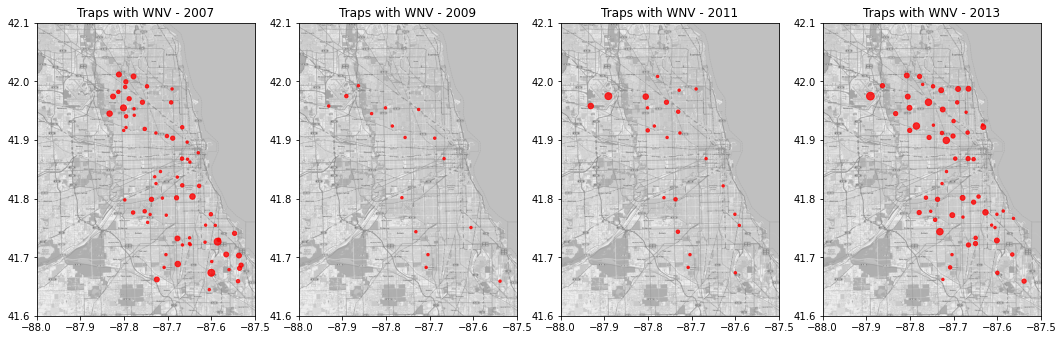

In [18]:
mapdata = np.loadtxt("../BackupData/mapdata_copyright_openstreetmap_contributors.txt/mapdata_copyright_openstreetmap_contributors.txt")
traps = pd.read_csv('../data/train.csv')[['Date', 'Trap','Longitude', 'Latitude', 'WnvPresent']]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)


# Plot for 2007
fig,ax = plt.subplots(figsize=(18,18), nrows=1, ncols=4)
ax[0].imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations_2007 = train_plot_2007.loc[:, ['longitude', 'latitude']]

ax[0].scatter(locations_2007['longitude'], locations_2007['latitude'],
            s=train_plot_2007.loc[:, ['wnvcount']]*6,
            alpha=0.8,
            c='red')
ax[0].set_title('Traps with WNV - 2007')


# Plot for 2009
ax[1].imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations_2009 = train_plot_2009.loc[:, ['longitude', 'latitude']]

ax[1].scatter(locations_2009['longitude'], locations_2009['latitude'],
            s=train_plot_2009.loc[:, ['wnvcount']]*6,
            alpha=0.8,
            c='red')
ax[1].set_title('Traps with WNV - 2009')

# Plot for 2011
ax[2].imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations_2011 = train_plot_2011.loc[:, ['longitude', 'latitude']]

ax[2].scatter(locations_2011['longitude'], locations_2011['latitude'],
            s=train_plot_2011.loc[:, ['wnvcount']]*6,
            alpha=0.8,
            c='red')
ax[2].set_title('Traps with WNV - 2011')

# Plot for 2013
ax[3].imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations_2013 = train_plot_2013.loc[:, ['longitude', 'latitude']]

ax[3].scatter(locations_2013['longitude'], locations_2013['latitude'],
            s=train_plot_2013.loc[:, ['wnvcount']]*6,
            alpha=0.8,
            c='red')
ax[3].set_title('Traps with WNV - 2013')

In [19]:
train_plot_2007_top = train_plot_2007.sort_values('wnvcount', ascending=False)[:5]
train_plot_2009_top = train_plot_2009.sort_values('wnvcount', ascending=False)[:5]
train_plot_2011_top = train_plot_2011.sort_values('wnvcount', ascending=False)[:5]
train_plot_2013_top = train_plot_2013.sort_values('wnvcount', ascending=False)[:5]

Text(0.5, 1.0, 'Traps with WNV - 2013')

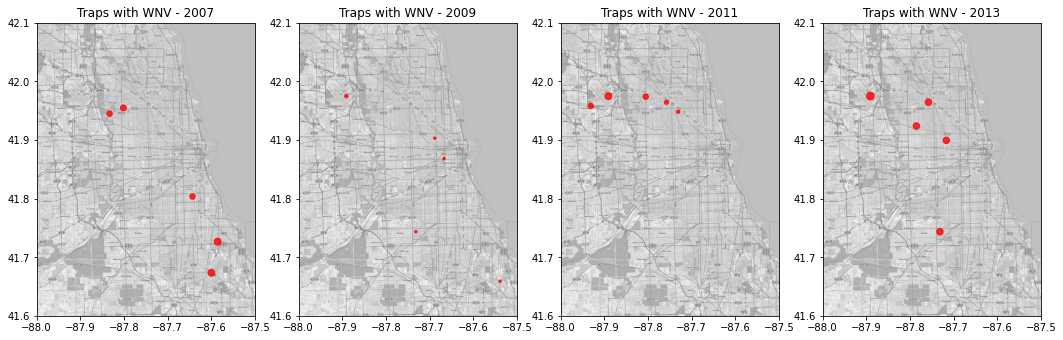

In [20]:
# Plot for 2007
fig,ax = plt.subplots(figsize=(18,18), nrows=1, ncols=4)
ax[0].imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations_2007 = train_plot_2007_top.loc[:, ['longitude', 'latitude']]

ax[0].scatter(locations_2007['longitude'], locations_2007['latitude'],
            s=train_plot_2007_top.loc[:, ['wnvcount']]*6,
            alpha=0.8,
            c='red')
ax[0].set_title('Traps with WNV - 2007')


# Plot for 2009
ax[1].imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations_2009 = train_plot_2009_top.loc[:, ['longitude', 'latitude']]

ax[1].scatter(locations_2009['longitude'], locations_2009['latitude'],
            s=train_plot_2009_top.loc[:, ['wnvcount']]*6,
            alpha=0.8,
            c='red')
ax[1].set_title('Traps with WNV - 2009')

# Plot for 2011
ax[2].imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations_2011 = train_plot_2011_top.loc[:, ['longitude', 'latitude']]

ax[2].scatter(locations_2011['longitude'], locations_2011['latitude'],
            s=train_plot_2011_top.loc[:, ['wnvcount']]*6,
            alpha=0.8,
            c='red')
ax[2].set_title('Traps with WNV - 2011')

# Plot for 2013
ax[3].imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations_2013 = train_plot_2013_top.loc[:, ['longitude', 'latitude']]

ax[3].scatter(locations_2013['longitude'], locations_2013['latitude'],
            s=train_plot_2013_top.loc[:, ['wnvcount']]*6,
            alpha=0.8,
            c='red')
ax[3].set_title('Traps with WNV - 2013')

In [86]:
test.columns

Index(['Id', 'Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy'],
      dtype='object')

In [180]:
v = train[['trap', 'longitude', 'latitude']]

In [193]:
trap = v.groupby(['trap', 'longitude', 'latitude'], as_index=False).count()

# XGBOOST

In [2]:
lag_train = pd.read_csv('../data/lag7_g1_pw.csv')
lag_test = pd.read_csv('../data/test_lag7_g1_pw.csv')

In [117]:
lag_train['id'] = list(range(1,8476))
lag_train['id']

0          1
1          2
2          3
3          4
4          5
        ... 
8470    8471
8471    8472
8472    8473
8473    8474
8474    8475
Name: id, Length: 8475, dtype: int64

In [3]:
X = lag_train.drop(columns = ['wnvpresent','date','id'])
y = lag_train['wnvpresent']

In [4]:
# Splitting X and y into training and testing datasets.

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

# Scaling X_train to the standard scale.

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)

# Transforming X_test to the same scale.

X_test_sc = ss.transform(X_test)


In [5]:
# fit XGBoost on training data

xbg_model = XGBClassifier(
    scale_pos_weight=40,
    learning_rate=1.6,  
    colsample_bytree = 0.41,
    subsample = 0.99,
    objective='binary:logistic',
    booster = 'dart',
    reg_alpha = 26,
    max_depth= 4, 
    min_child_weight = 3,
    use_label_encoder=False,
    eval_metric = 'error'
)

                      
eval_set = [(X_test_sc,y_test)]


# use AUC as eval matric
xbg_model.fit(
    X_train_sc,
    y_train,
    early_stopping_rounds=10,
    eval_set=eval_set,
    verbose = False,
    eval_metric='auc'
)

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.41,
              enable_categorical=False, eval_metric='error', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=1.6, max_delta_step=0, max_depth=4,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=26, reg_lambda=1, scale_pos_weight=40,
              subsample=0.99, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [14]:
preds = xbg_model.predict(X_test_sc)

In [127]:
max(list(y_test.index))
max(list(y_train.index))

8474

In [103]:
# create a dataframe containing the predicted and actual wnv in test set

y_test_pred_df = pd.DataFrame()
y_test_pred_df['index'] = y_test.index
y_test_pred_df['y'] = y_test.values

y_test_pred_df['y_pred'] = preds
y_test_pred_df = y_test_pred_df.merge(lag_train.reset_index(), on = 'index')

In [230]:
# merge data back with original data so we can get the trap and species columns

merge_df = pd.read_csv('../data/merged_train.csv')

merge_df['index'] = merge_df.index
train_original = merge_df[['trap', 'species', 'index']]

test_df = y_test_pred_df.merge(train_original, how='left', on='index')
test_df['date'] = pd.to_datetime(test_df['date'])
test_df['year'] = test_df['date'].dt.year
test_df['week'] = test_df['date'].dt.isocalendar().week

new_cols = list(test_df.columns[:7])
new_cols.extend(['trap', 'species', 'week', 'year'])

wrong_class = test_df[new_cols]

In [231]:
fn_filter = (wrong_class['y'] == 1) & (wrong_class['y_pred'] == 0)
fp_filter = (wrong_class['y'] == 0) & (wrong_class['y_pred'] == 1)

In [232]:
fn_only = wrong_class[fn_filter]
fp_only = wrong_class[fp_filter]

In [233]:
# proportion of traps missed out of test set by week

test_df.groupby('week')['wnvpresent'].sum()


test_week = pd.DataFrame(test_df.groupby('week')['wnvpresent'].sum())
test_week.columns = ['y_wnvpresent']
test_week['fn'] = fn_only.groupby('week')['wnvpresent'].sum()
test_week['prop_missed']=test_week['fn']/test_week['y_wnvpresent']
test_week

y_wnvpresent   fn  prop_missed
week                                
22             0.0  NaN          NaN
23             0.0  NaN          NaN
24             0.0  NaN          NaN
25             0.0  NaN          NaN
26             0.0  NaN          NaN
27             0.0  NaN          NaN
28             2.0  1.0     0.500000
29             5.0  2.0     0.400000
30             5.0  4.0     0.800000
31             9.0  3.0     0.333333
32            10.0  2.0     0.200000
33            25.0  9.0     0.360000
34            27.0  3.0     0.111111
35             6.0  1.0     0.166667
36            10.0  1.0     0.100000
37            10.0  3.0     0.300000
38             3.0  1.0     0.333333
39             2.0  NaN          NaN
40             0.0  NaN          NaN
41             0.0  NaN          NaN

In [234]:
# proportion of traps missed out of test set by year

test_df.groupby('year')['wnvpresent'].sum()


test_year = pd.DataFrame(test_df.groupby('year')['wnvpresent'].sum())
test_year.columns = ['y_wnvpresent']
test_year['fn'] = fn_only.groupby('year')['wnvpresent'].sum()
test_year['prop_missed']=test_year['fn']/test_year['y_wnvpresent']
test_year

y_wnvpresent    fn  prop_missed
year                                 
2007          52.0  11.0     0.211538
2009           4.0   3.0     0.750000
2011          12.0   3.0     0.250000
2013          46.0  13.0     0.282609

In [237]:
#merge_df['wnvpresent', 'species'].groupby('species')['wnvpresent']
test_species = pd.DataFrame(test_df.loc[test_df['wnvpresent']==1,'species'].value_counts())
test_species.columns = ['y_wnvpresent']
test_species['fn'] = fn_only.groupby('species')['wnvpresent'].sum()
test_species['prop_missed']=test_species['fn']/test_species['y_wnvpresent']
test_species

y_wnvpresent    fn  prop_missed
CULEX PIPIENS/RESTUANS            56  16.0     0.285714
CULEX PIPIENS                     45   8.0     0.177778
CULEX RESTUANS                    13   6.0     0.461538

In [243]:
merge_df.groupby('species')['wnvpresent'].mean()

species
CULEX ERRATICUS           0.000000
CULEX PIPIENS             0.094359
CULEX PIPIENS/RESTUANS    0.058808
CULEX RESTUANS            0.020059
CULEX SALINARIUS          0.000000
CULEX TARSALIS            0.000000
CULEX TERRITANS           0.000000
Name: wnvpresent, dtype: float64

In [181]:
missed_traps = fn_only['trap']
p_test_traps = test_df['trap']

In [ ]:
g1= ['T231',
 'T073',
 'T095',
 'T006',
 'T027',
 'T143',
 'T003',
 'T226',
 'T028',
 'T114',
 'T030',
 'T228',
 'T151',
 'T225',
 'T158',
 'T096',
 'T147',
 'T221',
 'T031',
 'T011',
 'T086',
 'T054',
 'T227',
 'T002',
 'T090',
 'T103',
 'T233',
 'T903',
 'T235',
 'T082',
 'T900',
 'T230',
 'T135',
 'T008',
 'T061',
 'T039',
 'T066',
 'T115',
 'T013',
 'T015',
 'T016',
 'T128',
 'T014',
 'T138',
 'T223',
 'T009']

In [244]:
unintended = [element for element in missed_traps if element not in g1]
unintended

['T212',
 'T215',
 'T047',
 'T159',
 'T047',
 'T154',
 'T045',
 'T033',
 'T048',
 'T162']

In [245]:
intended = [element for element in missed_traps if element in g1]
intended = list(set(d))
intended

['T073',
 'T900',
 'T228',
 'T227',
 'T031',
 'T225',
 'T138',
 'T090',
 'T115',
 'T028',
 'T221',
 'T008',
 'T002',
 'T066']

In [246]:
# Table of traps

fn_only.loc[fn_only['trap'].isin(intended),:].sort_values('trap')

index    y  y_pred       date   latitude  longitude  wnvpresent  trap  \
486    8396  1.0       0 2009-07-24  41.954690 -87.800991         1.0  T002   
1929   8205  1.0       0 2007-08-01  42.008314 -87.777921         1.0  T008   
1477   7471  1.0       0 2013-08-15  41.986921 -87.689778         1.0  T028   
1324   6860  1.0       0 2013-08-29  41.801498 -87.763416         1.0  T031   
415    8308  1.0       0 2011-07-29  41.801498 -87.763416         1.0  T031   
997    8202  1.0       0 2013-09-12  41.771660 -87.703047         1.0  T066   
1779   1014  1.0       0 2007-09-12  41.773215 -87.600880         1.0  T073   
1583   6997  1.0       0 2011-08-19  41.773215 -87.600880         1.0  T073   
1148   5885  1.0       0 2011-07-29  41.868077 -87.666901         1.0  T090   
1880   7323  1.0       0 2013-09-12  41.868077 -87.666901         1.0  T090   
1564   7634  1.0       0 2009-08-13  41.868077 -87.666901         1.0  T090   
1370   8473  1.0       0 2007-07-25  41.673408 -87.599862         1.0  T115   
211    8443  1.0       0 2007-09-06  41.726465 -87.585413         1.0  T138   
778    8377  1.0       0 2007-08-17  41.659112 -87.538693         1.0  T221   
85     5637  1.0       0 2013-08-01  41.743402 -87.731435         1.0  T225   
2018   4907  1.0       0 2013-08-08  41.728495 -87.600963         1.0  T227   
1317   7375  1.0       0 2013-08-22  41.728495 -87.600963         1.0  T227   
856    7886  1.0       0 2013-08-15  41.728495 -87.600963         1.0  T227   
2109   2868  1.0       0 2009-09-14  41.951866 -87.725057         1.0  T228   
1630   8394  1.0       0 2013-07-19  41.974689 -87.890615         1.0  T900   

                     species  week  year  
486   CULEX PIPIENS/RESTUANS    30  2009  
1929           CULEX PIPIENS    31  2007  
1477          CULEX RESTUANS    33  2013  
1324  CULEX PIPIENS/RESTUANS    35  2013  
415   CULEX PIPIENS/RESTUANS    30  2011  
997   CULEX PIPIENS/RESTUANS    37  2013  
1779           CULEX PIPIENS    37  2007  
1583  CULEX PIPIENS/RESTUANS    33  2011  
1148          CULEX RESTUANS    30  2011  
1880           CULEX PIPIENS    37  2013  
1564  CULEX PIPIENS/RESTUANS    33  2009  
1370           CULEX PIPIENS    30  2007  
211            CULEX PIPIENS    36  2007  
778   CULEX PIPIENS/RESTUANS    33  2007  
85            CULEX RESTUANS    31  2013  
2018          CULEX RESTUANS    32  2013  
1317  CULEX PIPIENS/RESTUANS    34  2013  
856   CULEX PIPIENS/RESTUANS    33  2013  
2109          CULEX RESTUANS    38  2009  
1630          CULEX RESTUANS    29  2013

In [196]:
# create time related features

merge_df['date']=pd.to_datetime(merge_df['date'])
merge_df['year'] = merge_df['date'].dt.year
merge_df['month'] = merge_df['date'].dt.month
merge_df['week'] = merge_df['date'].dt.isocalendar().week

# subset required columns and rows
betw_year = merge_df[['trap', 'year', 'wnvpresent', 'wnvcount']]
betw_year = betw_year.loc[betw_year['wnvpresent']>0,:]           # only rows where wnv is present

# Collapse by trap and year
betw_year = betw_year.groupby(['trap', 'year'], as_index=False)[['wnvpresent', 'wnvcount']]\
.sum().sort_values(['year','wnvpresent'], ascending=False)

ay = betw_year.groupby(['trap'], as_index=False)['wnvpresent',].sum()

In [200]:
ay[ay['trap'].isin(intended)].sort_values('wnvpresent')

trap  wnvpresent
35  T073         4.0
87  T227         4.0
15  T031         5.0
31  T066         6.0
88  T228         6.0
47  T090         7.0
81  T221         7.0
4   T008         9.0
13  T028         9.0
60  T138         9.0
85  T225        11.0
0   T002        15.0
57  T115        15.0
95  T900        29.0

In [247]:
#ay.sort_values('wnvpresent', ascending=False)[:20]

In [225]:
merge_df.loc[(merge_df['trap']=='T090')&(merge_df['wnvpresent']==1),:].sort_values('date')

date                 species   latitude  longitude  trap  \
8136 2007-08-01  CULEX PIPIENS/RESTUANS  41.868077 -87.666901  T090   
5515 2007-08-21           CULEX PIPIENS  41.868077 -87.666901  T090   
7634 2009-08-13  CULEX PIPIENS/RESTUANS  41.868077 -87.666901  T090   
5885 2011-07-29          CULEX RESTUANS  41.868077 -87.666901  T090   
6495 2013-08-29          CULEX RESTUANS  41.868077 -87.666901  T090   
7323 2013-09-12           CULEX PIPIENS  41.868077 -87.666901  T090   
5209 2013-09-19           CULEX PIPIENS  41.868077 -87.666901  T090   

      nummosquitos  wnvpresent  wnvcount  station  tmax  tmin  tavg  dewpoint  \
8136          61.0         1.0       1.0        2    91    69  80.0        63   
5515           7.0         1.0       1.0        2    85    69  77.0        70   
7634          29.0         1.0       1.0        2    86    63  74.5        55   
5885           8.0         1.0       1.0        2    86    74  80.0        69   
6495          12.0         1.0       1.0        2    87    69  78.0        65   
7323          21.0         1.0       1.0        2    83    63  73.0        58   
5209           6.0         1.0       1.0        2    84    70  77.0        66   

      wetbulb  heat  cool   codesum  preciptotal  stnpressure  sealevel  \
8136     70.0   0.0  15.0                  0.000        29.34     29.98   
5515     72.0   0.0  12.0        BR        0.010        29.26     29.89   
7634     63.0   0.0  10.0                  0.000        29.44     30.09   
5885     72.0   0.0  15.0   TSRA BR        0.360        29.34     29.96   
6495     69.0   0.0  13.0  FG BR HZ        0.000        29.36     30.00   
7323     64.0   0.0   8.0                  0.060        29.34     29.97   
5209     69.0   0.0  12.0  RA BR HZ        0.005        29.21     29.87   

      resultspeed  resultdir  avgspeed  month   sunrise     sunset  bcfg  br  \
8136          2.1         13       3.7      8  4.750000  19.183333     0   0   
5515          3.5         17       6.0      8  5.083333  18.750000     0   1   
7634          2.0         16       4.0      8  4.950000  18.933333     0   0   
5885          3.5          4       5.6      7  4.700000  19.250000     0   1   
6495          4.2         10       4.6      8  5.233333  18.533333     0   1   
7323          6.8         34       9.8      9  5.466667  18.150000     0   0   
5209          7.8         16      10.0      9  5.600000  17.916667     0   1   

      dz  fg  fg+  fu  hz  mifg  ra  sn  sq  ts  tsra  vcts   gr  vcfg  \
8136   0   0    0   0   0   0.0   0   0   0   0     0     0  0.0   0.0   
5515   0   0    0   0   0   0.0   0   0   0   0     0     0  0.0   0.0   
7634   0   0    0   0   0   0.0   0   0   0   0     0     0  0.0   0.0   
5885   0   0    0   0   0   0.0   0   0   0   0     1     0  0.0   0.0   
6495   0   1    0   0   1   0.0   0   0   0   0     0     0  0.0   0.0   
7323   0   0    0   0   0   0.0   0   0   0   0     0     0  0.0   0.0   
5209   0   0    0   0   1   0.0   1   0   0   0     0     0  0.0   0.0   

      sprayed  index  year  week  
8136        0   8136  2007    31  
5515        0   5515  2007    34  
7634        0   7634  2009    33  
5885        0   5885  2011    30  
6495        0   6495  2013    35  
7323        0   7323  2013    37  
5209        0   5209  2013    38

In [226]:
new_df.loc[(new_df['trap']=='T090')&(new_df['wnvpresent']==1),:].sort_values('date')

index    y  y_pred       date   latitude  longitude  wnvpresent  \
1564   7634  1.0       0 2009-08-13  41.868077 -87.666901         1.0   
1148   5885  1.0       0 2011-07-29  41.868077 -87.666901         1.0   
1880   7323  1.0       0 2013-09-12  41.868077 -87.666901         1.0   

      culex_pipiens/restuans  culex_pipiens  culex_restuans  week_28  week_29  \
1564                       1              0               0        0        0   
1148                       0              0               1        0        0   
1880                       0              1               0        0        0   

      week_30  week_31  week_32  week_33  week_34  week_35  week_36  week_37  \
1564        0        0        0        1        0        0        0        0   
1148        1        0        0        0        0        0        0        0   
1880        0        0        0        0        0        0        0        1   

      week_38  week_39  trap_T086  trap_T003  trap_T028  ...  trap_T235  \
1564        0        0          0          0          0  ...          0   
1148        0        0          0          0          0  ...          0   
1880        0        0          0          0          0  ...          0   

      trap_T008  trap_T061  trap_T147  trap_T073  id  tavg  dewpoint  \
1564          0          0          0          0 NaN  71.5        51   
1148          0          0          0          0 NaN  85.5        70   
1880          0          0          0          0 NaN  69.5        53   

      preciptotal  stnpressure  sealevel  resultdir  avgspeed  sunset  br  fu  \
1564         0.00        29.44     30.08          9       5.5   19.10   0   0   
1148         0.14        29.23     29.86         10       8.2   19.35   1   0   
1880         0.00        29.55     30.19          6       9.9   18.35   0   0   

      hz  ra  ts  tsra  vcts  trap                 species  year  week  
1564   0   0   0     0     0  T090  CULEX PIPIENS/RESTUANS  2009    33  
1148   0   0   1     1     0  T090          CULEX RESTUANS  2011    30  
1880   0   0   0     0     0  T090           CULEX PIPIENS  2013    37  

[3 rows x 88 columns]

In [ ]:
1148	5885	1.0	0	2011-07-29	41.868077	-87.666901	1.0	T090	CULEX RESTUANS	30	2011
1880	7323	1.0	0	2013-09-12	41.868077	-87.666901	1.0	T090	CULEX PIPIENS	37	2013
1564	7634	1.0	0	2009-08-13	41.868077	-87.666901	1.0	T090	CULEX PIPIENS/RESTUANS	33	2009

In [185]:
len(c) +len(d)

30

TypeError: set expected at most 1 argument, got 46

C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


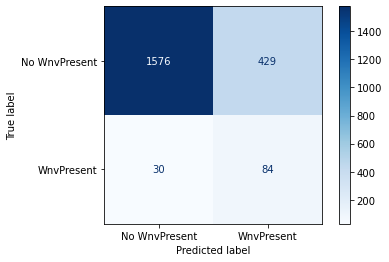

In [12]:
# Plot Confusion matrix
plot_confusion_matrix(xbg_model, X_test_sc, y_test, cmap='Blues', 
                      values_format='d', display_labels=['No WnvPresent', 'WnvPresent']);         

In [ ]:
# create a dataframe containing the predicted and actual wnv in test set

y_test_pred_df = pd.DataFrame()
y_test_pred_df['index'] = y_test.index
y_test_pred_df['y'] = y_test.values

y_test_pred_df['y_pred'] = preds
y_test_pred_df = y_test_pred_df.merge(lag_train.reset_index(), on = 'index')

In [ ]:
# merge data back with original data so we can get the trap and species columns

merge_df = pd.read_csv('../data/merged_train.csv')

merge_df['index'] = merge_df.index
train_original = merge_df[['trap', 'species', 'index']]

test_df = y_test_pred_df.merge(train_original, how='left', on='index')
test_df['date'] = pd.to_datetime(test_df['date'])
test_df['year'] = test_df['date'].dt.year
test_df['week'] = test_df['date'].dt.isocalendar().week

new_cols = list(test_df.columns[:5])
new_cols.extend(['trap', 'species', 'week', 'year'])

wrong_class = test_df[new_cols]

In [ ]:
fn_filter = (wrong_class['y'] == 1) & (wrong_class['y_pred'] == 0)
fn_only = wrong_class[fn_filter]

In [ ]:
# proportion of traps missed out of test set by year

test_df.groupby('year')['wnvpresent'].sum()


test_year = pd.DataFrame(test_df.groupby('year')['wnvpresent'].sum())
test_year.columns = ['y_wnvpresent']
test_year['fn'] = fn_only.groupby('year')['wnvpresent'].sum()
test_year['prop_missed']=test_year['fn']/test_year['y_wnvpresent']
test_year

In [ ]:
# proportion of traps missed out of test set by week

test_df.groupby('week')['wnvpresent'].sum()


test_week = pd.DataFrame(test_df.groupby('week')['wnvpresent'].sum())
test_week.columns = ['y_wnvpresent']
test_week['fn'] = fn_only.groupby('week')['wnvpresent'].sum()
test_week['prop_missed']=test_week['fn']/test_week['y_wnvpresent']
test_week

In [ ]:
# merge_df['wnvpresent', 'species'].groupby('species')['wnvpresent']
test_species = pd.DataFrame(test_df.loc[test_df['wnvpresent']==1,'species'].value_counts())
test_species.columns = ['y_wnvpresent']
test_species['fn'] = fn_only.groupby('species')['wnvpresent'].sum()
test_species['prop_missed']=test_species['fn']/test_species['y_wnvpresent']
test_species

In [ ]:
merge_df.groupby('species')['wnvpresent'].mean()

In [ ]:
missed_traps = fn_only['trap']
g1= ['T231',
 'T073',
 'T095',
 'T006',
 'T027',
 'T143',
 'T003',
 'T226',
 'T028',
 'T114',
 'T030',
 'T228',
 'T151',
 'T225',
 'T158',
 'T096',
 'T147',
 'T221',
 'T031',
 'T011',
 'T086',
 'T054',
 'T227',
 'T002',
 'T090',
 'T103',
 'T233',
 'T903',
 'T235',
 'T082',
 'T900',
 'T230',
 'T135',
 'T008',
 'T061',
 'T039',
 'T066',
 'T115',
 'T013',
 'T015',
 'T016',
 'T128',
 'T014',
 'T138',
 'T223',
 'T009']

In [ ]:
unintended = [element for element in missed_traps if element not in g1]
unintended

In [ ]:
intended = [element for element in missed_traps if element in g1]
intended = list(set(intended))
intended

In [ ]:
# Table of traps

fn_only.loc[fn_only['trap'].isin(intended),:].sort_values(['trap'])

In [ ]:
# create time related features

merge_df['date']=pd.to_datetime(merge_df['date'])
merge_df['year'] = merge_df['date'].dt.year
merge_df['month'] = merge_df['date'].dt.month
merge_df['week'] = merge_df['date'].dt.isocalendar().week

# subset required columns and rows
betw_year = merge_df[['trap', 'year', 'wnvpresent', 'wnvcount']]
betw_year = betw_year.loc[betw_year['wnvpresent']>0,:]           # only rows where wnv is present

# Collapse by trap and year
betw_year = betw_year.groupby(['trap', 'year'], as_index=False)[['wnvpresent', 'wnvcount']]\
.sum().sort_values(['year','wnvpresent'], ascending=False)

ay = betw_year.groupby(['trap'], as_index=False)['wnvpresent',].sum()

In [ ]:
ay[ay['trap'].isin(intended)].sort_values('wnvpresent')

In [ ]:
Looking at the 'prop_missed' column, we can see the proportion of traps missed by the model (ie. sensitivity by week). The model was generally better at detecting WNV for weeks that had higher WNV counts (weeks 32 to 36), and weaker for the other weeks. This is expected as the peak of the WNV wave is at week 33, and the model would likely have placed higher importance on weeks around 33.

Nonetheless, it shows that the model is poor at picking up occurences of WNVpresent at the onset and the tail end of the WNV wave.

In [ ]:
Looking at the 'prop_missed' column once again, we can see that there is a higher propoortion missed for CULEX PIPIENS/RETUANS and CULEX RESTUANS as compared to CULEX PIPIENS. This is not surprising as the proportion of CULEX PIPIENS which carry the WNV is HIGHER than CULEX RESTUANS AND CULEX PIPIENS/RESTUANS. (See below)

At this point in time, we do not foresee this to be a big concern as the model can successfully pick up the most 'dangerous' mosquito species.

In [ ]:
Of the traps which were included in the model (dummy coded), but not picked up in analysis, they largely appear to be in the weeks with lower WNV counts (ie outside of week 32 to 36). Of those which are around the peak weeks, the mosquitos belong to the species that have lower likelihood of carrying the WNV.

In [ ]:
**Error Analysis Remarks**

In general, the model performed within our expectations. The model is able to pick up WNV infected mosquitos which are of a certain species and within the peak weeks. However, we note that certain traps will be missed out in its entirety as the have not been included in the model.

**Future Directions**
1) Assuming that the CULEX PIPIENS/RESTUANS category with both species, we would expect that the model would perform better if they were distinguished well. As such we reccomend that future data collection for mosquito species to take more time to ensure that the species are identified correctly.

2) While the inclusion of trap locations seem to be sufficient for prediction at this point in time, we note that it will inevitably leave out traps which have rare WNV cases. We suggest for future models to model location clusters as hotspots rather than specific traps to have a better capture of high WNV risk areas.

3) The model is currently effective at picking out WNV presence at the peak of the wave rather then the start or end of the wave. We recommend to build future models to be more sensitive to the onset of the WNV wave as that would be the best time to tackel the issue.